# Forecasting Homeless Shelter Demand for Effective Resource Allocation

### Data Science 3000 Group Project

By: Aaron Serro, Kalan Roye, Jisa Pius, Tina Movahedi


### Step 1: Importing and loading the data


In [ ]:
# Importing nessessary libraries
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib

# Loading Dataset
df = pd.read_csv("homelessness_shelter_data.csv")
df.head()

,id,date,shelter_name,city,state,total_capacity,occupied_beds,available_beds,occupancy_rate,average_age,male_percentage,female_percentage,season,notes
0,1,2023-10-05,Sunrise Shelter,Dallas,TX,85,62,23,72.9,19,43,57,Spring,High demand
1,2,2023-08-01,Safe Haven,Dallas,TX,128,117,11,91.4,58,45,55,Summer,No issues reported
2,3,2025-04-27,Second Chance,San Jose,CA,190,144,46,75.8,56,52,48,Summer,Excellent condition
3,4,2024-10-05,Harbor Home,San Jose,CA,115,7,108,6.1,63,48,52,Autumn,Needs maintenance
4,5,2024-09-15,Harbor Home,San Antonio,TX,155,65,90,41.9,21,48,52,Summer,No issues reported


In [ ]:
# Summary Statistics

print("shape -", df.shape)
df.describe()

shape - (1000, 14)


,id,total_capacity,occupied_beds,available_beds,occupancy_rate,average_age,male_percentage,female_percentage
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,179.123000,91.874000,87.249000,51.214700,42.037000,54.634000,45.366000
std,288.819436,73.419195,67.068937,65.531224,28.880331,13.768122,8.797468,8.797468
min,1.000000,50.000000,0.000000,0.000000,0.000000,18.000000,40.000000,30.000000
25%,250.750000,115.000000,38.000000,35.000000,26.775000,30.000000,47.000000,38.000000
50%,500.500000,182.000000,76.000000,71.000000,51.850000,42.000000,55.000000,45.000000
75%,750.250000,243.000000,136.000000,128.250000,76.800000,54.000000,62.000000,53.000000
max,1000.000000,300.000000,294.000000,296.000000,100.000000,65.000000,70.000000,60.000000


### Step 2: Cleaning and preprocessing the data


In [ ]:
# Handling missing values
df.isna().sum()
df[df.isna().any(axis=1)]
df.replace(["N/A", "na", "?", "missing"], pd.NA, inplace=True)

# Fixing Datatypes
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["id"] = df["id"].astype(str)

# Removing duplicates
df.drop_duplicates(inplace=True)

# Handling outliers
numeric_cols = df.select_dtypes(include=["number"]).columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    print(f"{col}: {len(outliers)} outliers")

total_capacity: 0 outliers
occupied_beds: 1 outliers
available_beds: 10 outliers
occupancy_rate: 0 outliers
average_age: 0 outliers
male_percentage: 0 outliers
female_percentage: 0 outliers


### Step 3: Feature Engineering - adding variables to assist in model training and data analysis


In [ ]:
# Feature Engineering
# This variable is for beds available but not filled
df["unmet_demand"] = df["total_capacity"] - df["occupied_beds"]
# column needs to be removed
df["overcapacity_flag"] = (
    df["occupied_beds"] > df["total_capacity"]).astype(int)
df.drop("overcapacity_flag", axis=1, inplace=True)
# This variable is going to be used to see by how much is the shelter overcapacitated, if negitive then undercapacitated
df["capacity_gap_ratio"] = (
    df["occupied_beds"] - df["total_capacity"]) / df["total_capacity"]
# ratio of men to women: if >1 then more men, if <1 more women
df["gender_balance_ratio"] = df["male_percentage"] / df["female_percentage"]
# absolute difference between men and women
df["gender_gap"] = abs(df["male_percentage"] - df["female_percentage"])
# Column needs to be removed
df["predominant_gender"] = np.where(
    df["male_percentage"] > df["female_percentage"], "Male", "Female")
df.drop("predominant_gender", axis=1, inplace=True)
# Column needs to be removed
df["utilization_efficiency"] = df["occupied_beds"] / df["total_capacity"]
df.drop("utilization_efficiency", axis=1, inplace=True)
# Percentage of beds that are unsed
df["unused_bed_percent"] = (df["available_beds"] / df["total_capacity"]) * 100
df["pressure_index"] = (df["occupied_beds"] /
                        df["total_capacity"]) * (100 - df["available_beds"])
df["resource_stress_level"] = pd.cut(
    df["occupancy_rate"],
    bins=[0, 0.6, 0.8, 0.9, 1.1],
    labels=["Low", "Medium", "High", "Critical"]
)

In [ ]:
# Show new variables added to dataset
df.describe()

,date,total_capacity,occupied_beds,available_beds,occupancy_rate,average_age,male_percentage,female_percentage,unmet_demand,capacity_gap_ratio,gender_balance_ratio,gender_gap,unused_bed_percent,pressure_index
count,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2024-07-16 03:37:26.400000,179.123000,91.874000,87.249000,51.214700,42.037000,54.634000,45.366000,87.249000,-0.487848,1.294896,16.384000,48.784764,21.190160
min,2023-07-30 00:00:00,50.000000,0.000000,0.000000,0.000000,18.000000,40.000000,30.000000,0.000000,-1.000000,0.666667,0.000000,0.000000,-33.110368
25%,2024-01-17 18:00:00,115.000000,38.000000,35.000000,26.775000,30.000000,47.000000,38.000000,35.000000,-0.732440,0.886792,7.500000,23.176789,-5.346363
50%,2024-07-12 00:00:00,182.000000,76.000000,71.000000,51.850000,42.000000,55.000000,45.000000,71.000000,-0.481875,1.222222,14.000000,48.187549,12.112914
75%,2025-01-09 06:00:00,243.000000,136.000000,128.250000,76.800000,54.000000,62.000000,53.000000,128.250000,-0.231768,1.631579,24.000000,73.244048,46.259630
max,2025-07-29 00:00:00,300.000000,294.000000,296.000000,100.000000,65.000000,70.000000,60.000000,296.000000,0.000000,2.333333,40.000000,100.000000,100.000000
std,NaN,73.419195,67.068937,65.531224,28.880331,13.768122,8.797468,8.797468,65.531224,0.288810,0.475697,11.263188,28.880981,34.498163


### Step 3: Exploratory data analysis - seeing what our data looks like visually, and what that means


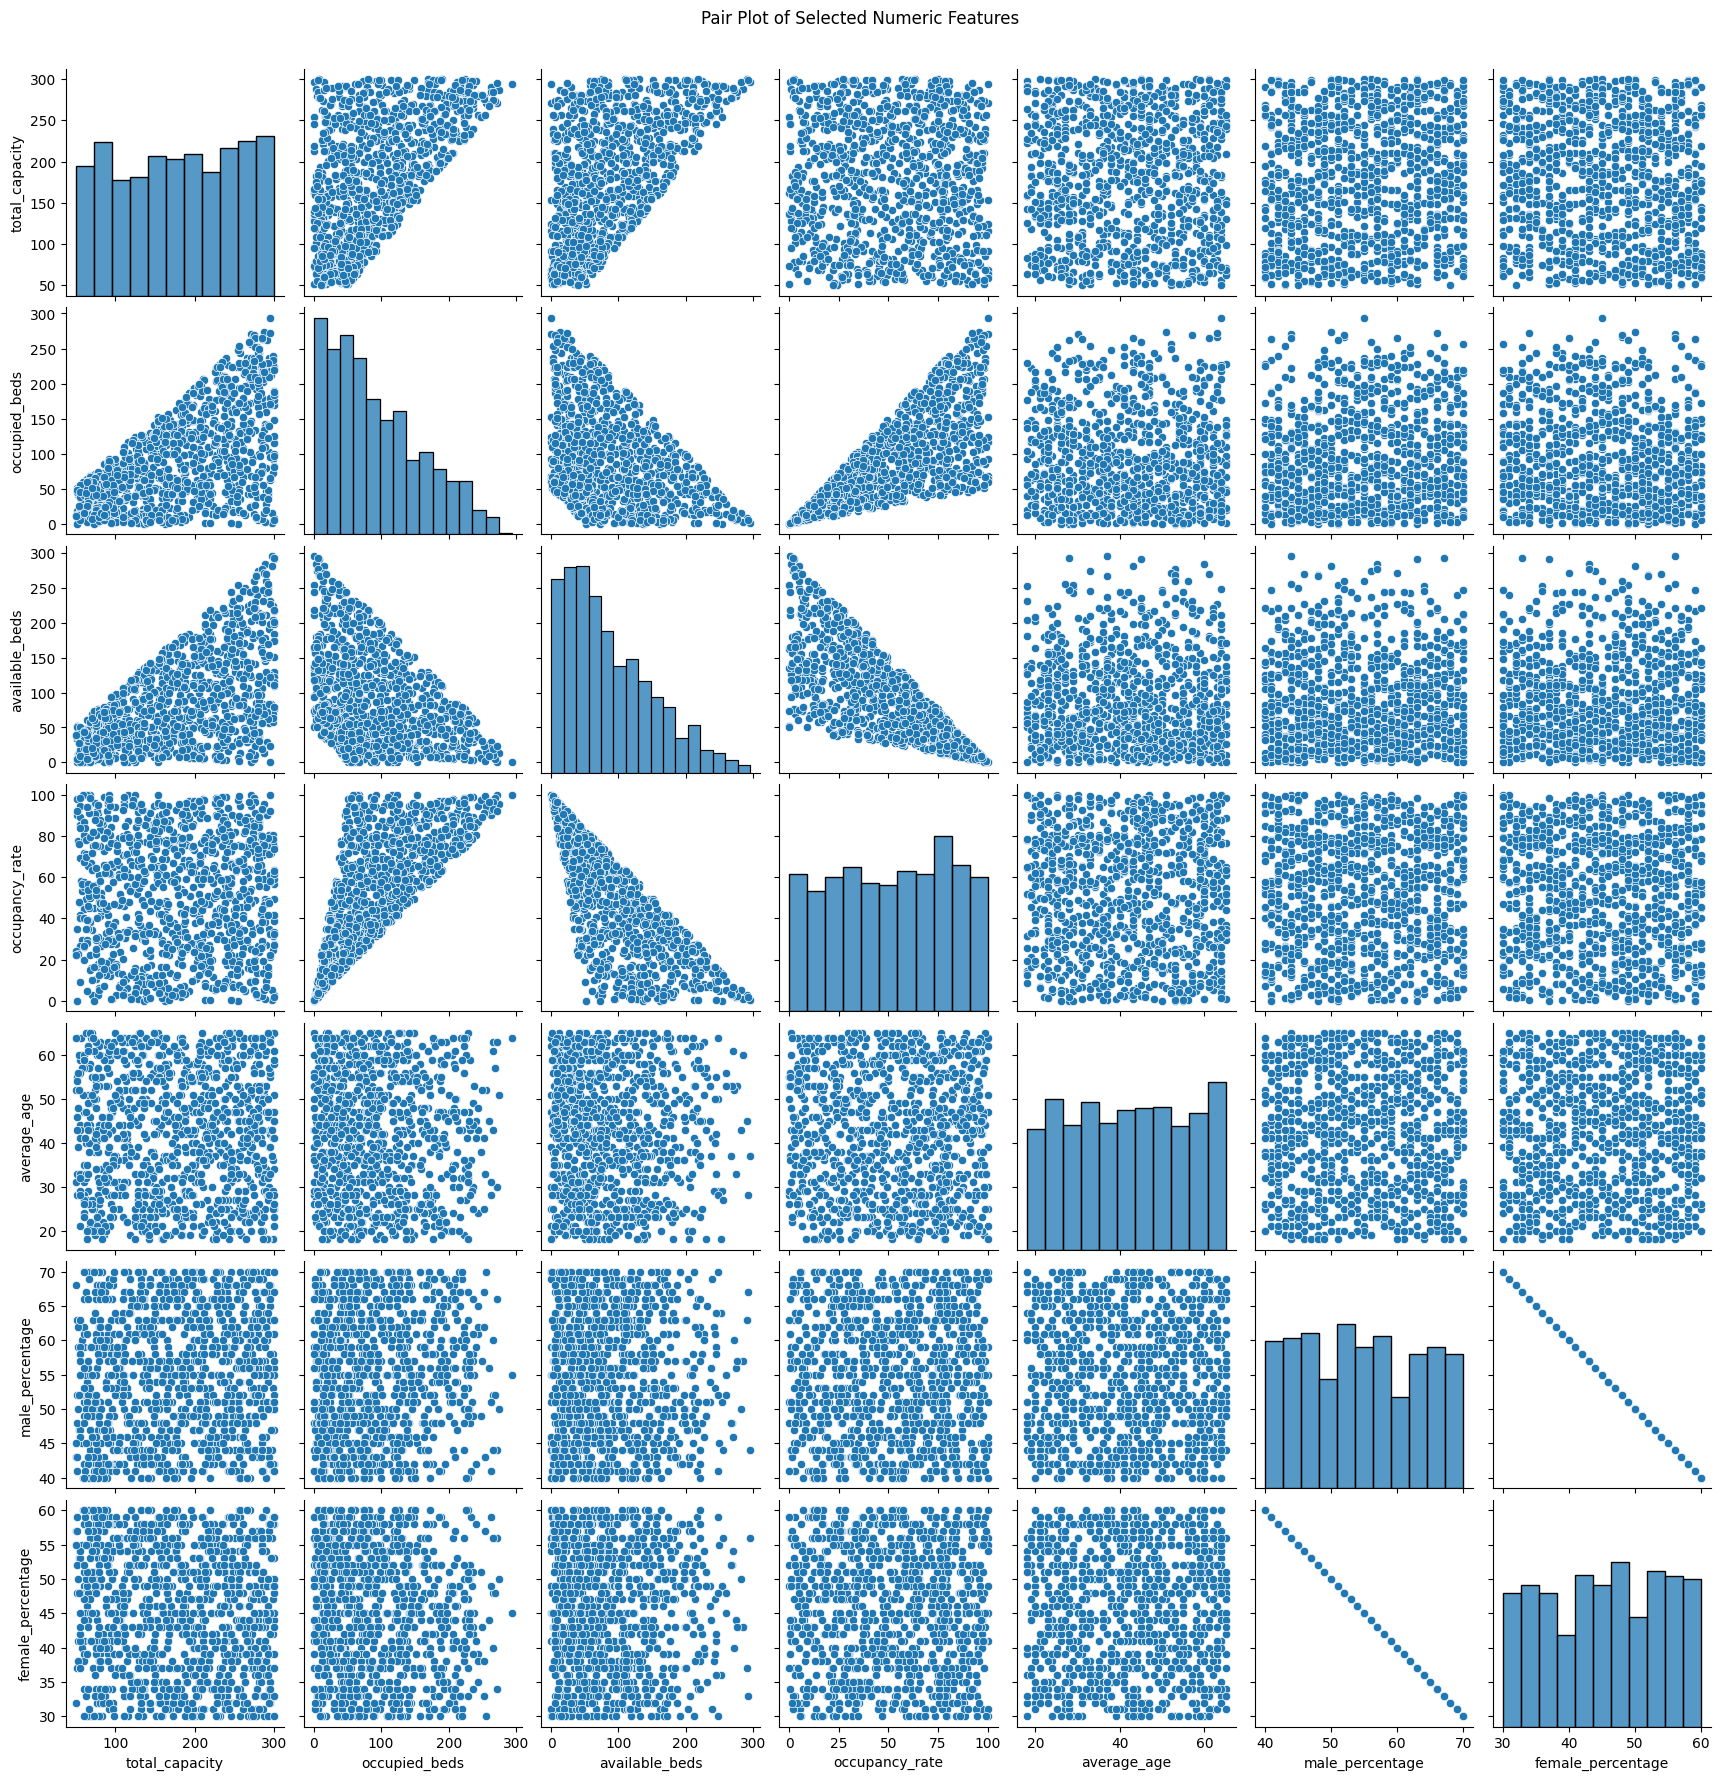

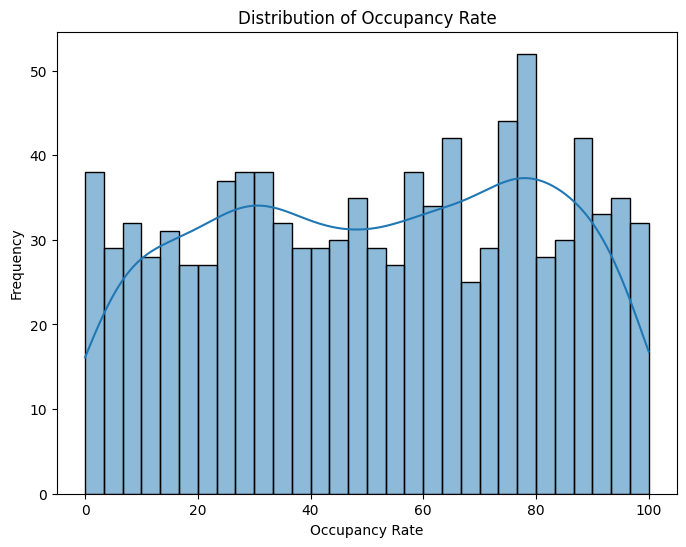

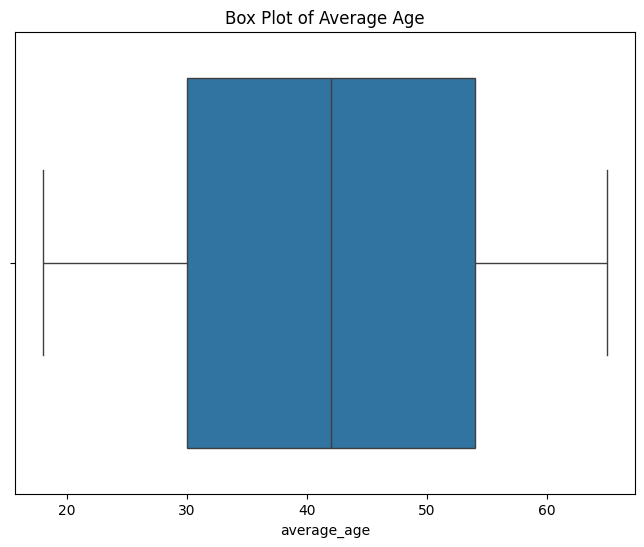

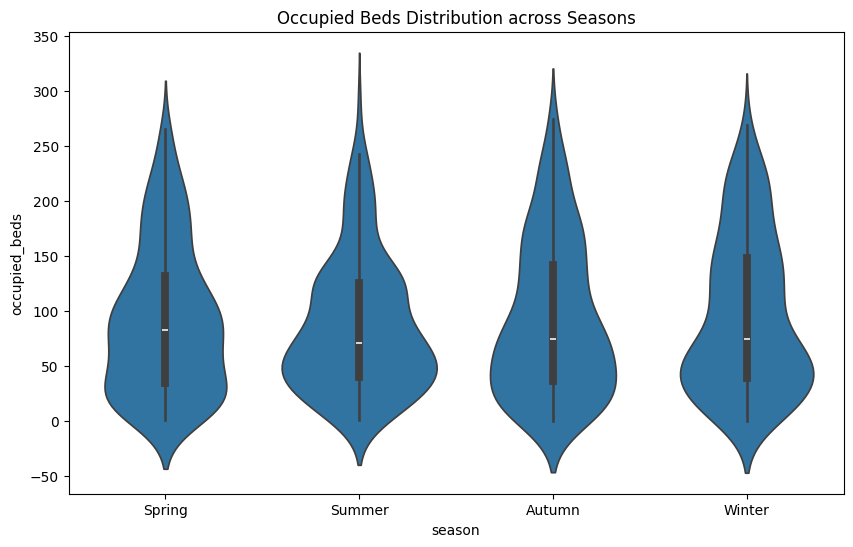

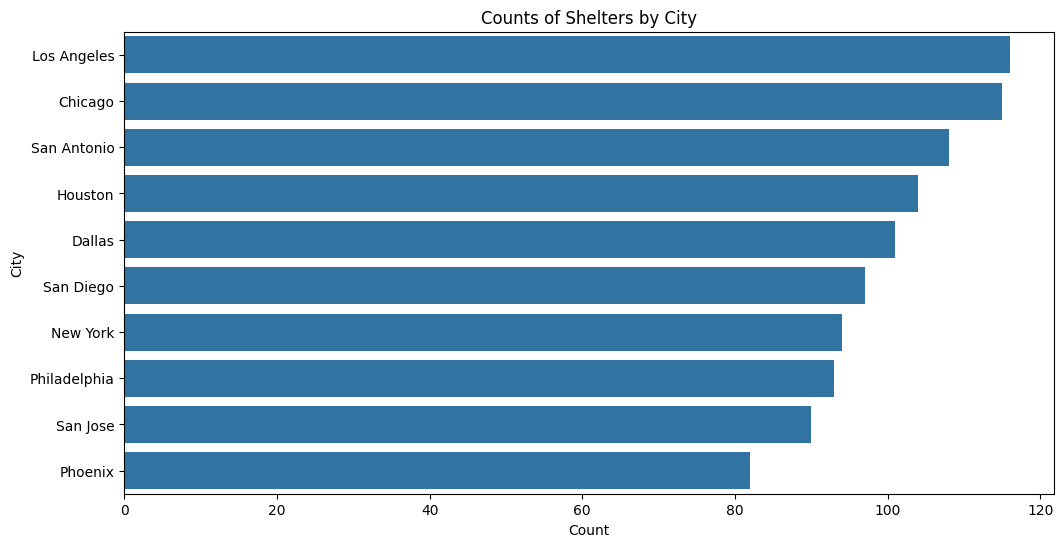

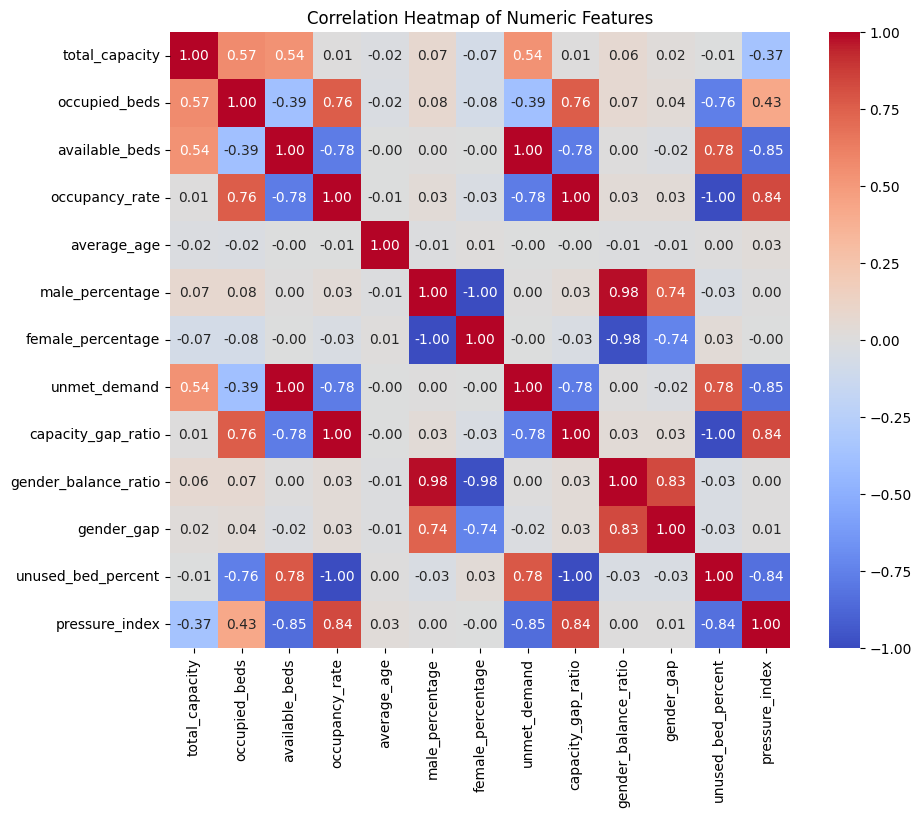

In [ ]:
'''Univariate Analysis'''
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df.select_dtypes(include=["number"]).columns

# Pair Plot: considering a few numeric columns only to avoid overcrowding
numeric_cols = ['total_capacity', 'occupied_beds', 'available_beds',
                'occupancy_rate', 'average_age', 'male_percentage', 'female_percentage']
sns.pairplot(df[numeric_cols])
plt.suptitle('Pair Plot of Selected Numeric Features', y=1.02)
plt.show()

# Histogram for Occupancy Rate
plt.figure(figsize=(8, 6))
sns.histplot(df['occupancy_rate'], kde=True, bins=30)
plt.title('Distribution of Occupancy Rate')
plt.xlabel('Occupancy Rate')
plt.ylabel('Frequency')
plt.show()

# Box Plot for Average Age
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['average_age'])
plt.title('Box Plot of Average Age')
plt.show()

# Violin Plot for Capacity vs Occupied Beds
plt.figure(figsize=(10, 6))
sns.violinplot(x='season', y='occupied_beds', data=df)
plt.title('Occupied Beds Distribution across Seasons')
plt.show()

# Count Plot (Pie Chart alternative) for Shelters by City
plt.figure(figsize=(12, 6))
sns.countplot(y='city', data=df, order=df['city'].value_counts().index)
plt.title('Counts of Shelters by City')
plt.xlabel('Count')
plt.ylabel('City')
plt.show()

# If there are four or more numeric columns, create a correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()